# Working with M-lab without knowing R
## Decennial anniversary workshop

This notebook goes along with a workshop on using M-lab data in R through Jupyter, and contains a lot of the same functionality as what's in the more comprehensive M-lab tutorial. What makes this notebook special is the ease-of-use. Even without understanding R or Jupyter, someone can use this code to produce visualizations of M-lab data for different countries, regions, and time periods. Those visualizations include line graphs of different quartiles, line graphs of the number of users per month, and choropleth maps of internet speeds in a given region. Enjoy!

### Load libraries and packages
As usual, the first cell in the notebook loads the needed R packages and defines the needed user functions. If you're copying this code locally, the library calls might fail the first time you run them. Instead, replace library() with install.packages() to install the desired packages. For a descrition of what these functions are actually doing, turn to the R tutorial and the R+M-lab tutorial.

In [12]:
library(tidyverse)
library(lubridate)
library(RColorBrewer)
library(reshape2)
library(bigrquery)
library(viridis)
library(tidycensus)
library(sp)
library(sf)

In [1]:
project <- "mlab-sandbox"

pull_ndt_data<-function(start_date, end_date, country_q, query=NULL, region=NULL, region.abv=NULL){
  if(is.null(query)==TRUE){
    if((is.null(region)==FALSE)&&(is.null(region.abv)==FALSE)==TRUE){
      query <- "#standardSQL
      SELECT
      ndt.log_time AS day,
      ndt.connection_spec.client_ip AS ip,
      ndt.connection_spec.client_geolocation.latitude AS lat,
      ndt.connection_spec.client_geolocation.longitude AS lon,
      8 * (ndt.web100_log_entry.snap.HCThruOctetsAcked /
      (ndt.web100_log_entry.snap.SndLimTimeRwin +
      ndt.web100_log_entry.snap.SndLimTimeCwnd +
      ndt.web100_log_entry.snap.SndLimTimeSnd)) AS d_mps,
      ndt.web100_log_entry.snap.MinRTT AS minRTT,
      ndt.connection_spec.server_geolocation.city AS city,
      ndt.connection_spec.client_geolocation.region AS client_region
      FROM
      `measurement-lab.release.ndt_downloads` AS ndt
      WHERE
      ndt.log_time BETWEEN DATE1 AND DATE2
      AND
      (
      ndt.connection_spec.client_geolocation.region = REGION
      OR ndt.connection_spec.client_geolocation.region = REGIONABV
      )AND
      connection_spec.client_geolocation.country_name = COUNTRY_NAME;
      "
      D.return<-data.frame()
      region.loc<-str_locate(query, "REGION")
      region.fir<-str_sub(query, 1,region.loc[1]-1)
      region.last<-str_sub(query, region.loc[2]+1, nchar(query))
      region.q<-str_c("'",region,"'")
      query<-str_c(region.fir, region.q, region.last)
      
      region.abv.loc<-str_locate(query, "REGIONABV")
      region.abv.fir<-str_sub(query, 1,region.abv.loc[1]-1)
      region.abv.last<-str_sub(query, region.abv.loc[2]+1, nchar(query))
      region.abv.q<-str_c("'",region.abv,"'")
      query<-str_c(region.abv.fir, region.abv.q, region.abv.last)
      
      
    }else{
      query <- "#standardSQL
    SELECT
    ndt.log_time AS day,
    ndt.connection_spec.client_ip AS ip,
    ndt.connection_spec.client_geolocation.latitude AS lat,
    ndt.connection_spec.client_geolocation.longitude AS lon,
    8 * (ndt.web100_log_entry.snap.HCThruOctetsAcked /
    (ndt.web100_log_entry.snap.SndLimTimeRwin +
    ndt.web100_log_entry.snap.SndLimTimeCwnd +
    ndt.web100_log_entry.snap.SndLimTimeSnd)) AS d_mps,
    ndt.web100_log_entry.snap.MinRTT AS minRTT,
    ndt.connection_spec.server_geolocation.city AS city,
    ndt.connection_spec.client_geolocation.region AS client_region
    FROM
    `measurement-lab.release.ndt_downloads` AS ndt
    WHERE
    ndt.log_time BETWEEN DATE1 AND DATE2
    AND
    connection_spec.client_geolocation.country_name = COUNTRY_NAME;
    "
    }
  }else{
    if((is.null(region)==FALSE)&&(is.null(region.abv)==FALSE)==TRUE){
      D.return<-data.frame()
      region.loc<-str_locate(query, "region")
      region.fir<-str_sub(query, 1,region.loc[1]-1)
      region.last<-str_sub(query, region.loc[2]+1, nchar(query))
      query<-str_c(region.fir, region, region.last)
      
      region.abv.loc<-str_locate(query, "REGIONABV")
      region.abv.fir<-str_sub(query, 1,region.abv.loc[1]-1)
      region.abv.last<-str_sub(query, region.abv.loc[2]+1, nchar(query))
      region.abv.q<-str_c("'",region.abv,"'")
      query<-str_c(region.abv.fir, region.abv.q, region.abv.last)
    }
  }
  
  
  country.loc<-str_locate(query, "COUNTRY_NAME")
  country.loc.fir<-str_sub(query, 1,country.loc[1]-1)
  country.loc.last<-str_sub(query, country.loc[2]+1, nchar(query))
  country_q<-str_c("'",country_q,"'")
  query<-str_c(country.loc.fir, country_q, country.loc.last)

  start.query<-query

  date_1<-start_date
  date_2<-end_date
  date_1b<-str_c("'",date_1,"'")
  date_2<-str_c("'",date_2,"'")
  
  date.loc<-str_locate(query, "DATE1")
  date.fir<-str_sub(query, 1,date.loc[1]-1)
  date.last<-str_sub(query, date.loc[2]+1, nchar(query))
  query<-str_c(date.fir, date_1b, date.last)
  
  date.loc<-str_locate(query, "DATE2")
  date.fir<-str_sub(query, 1,date.loc[1]-1)
  date.last<-str_sub(query, date.loc[2]+1, nchar(query))
  query<-str_c(date.fir, date_2, date.last)
  
  todo_copies <- query_exec(query, project = project, use_legacy_sql=FALSE, max_pages = Inf)
  todo_copies$day<-str_sub(todo_copies$day,1,7)
  todo_copies$day<-parse_date_time(todo_copies$day, "y-m")

  
  return(todo_copies)
  
}
iqr_plot <-function(D, cutoff_date, titles, D.to.join=NULL, labs){
  D<-med.D<-D%>%group_by(ip, day)%>%summarise("num"=median(d_mps))
  res<-D%>%data.frame()%>%group_by(day)%>%
    summarise("min"=summary(num)[1],"1q"=summary(num)[2], "med"=summary(num)[3], "mea"=summary(num)[4],
              "3q"=summary(num)[5], "max"=summary(num)[6], "num"=n())
  res$day<-ymd(res$day)
  
  if(class(D.to.join)[1]!="NULL"){
    res1<-left_join(res, D.to.join)
    res1<-res1%>%filter(day>ymd(cutoff_date))
    var.l<-c(2,3,5,10)
  }else{
    res1<-res%>%filter(day>ymd(cutoff_date))
    var.l<-c(2,3,5)
  }
  
  res1<-melt(res1, variable.name = "keys", value.name = "speeds", id.vars = "day")
  res1<-data.frame("day"=ymd(res1$day), "sum_type"=as.factor(res1$keys), "speed"=as.numeric(res1$speeds))
  
  plasma_pal <- magma(5)[c(1,4,2)]
  plasma_pal<-c(plasma_pal,alpha(c("#C0C0C0","#C0C0C0"),.7 ))
  
  res1%>%filter(sum_type%in%levels(res1$sum_type)[var.l])%>%ggplot(aes(x=day, y = speed, col=sum_type))+
    geom_line(size =.6)+theme_scatter()+labs(x = "Dates", y = "Mbps",title = titles)+
    scale_color_manual(values = plasma_pal, labels=labs, name="")
    
}



theme_scatter <- function(...) {
  theme_minimal() +
    theme(
      text = element_text(family = "Ubuntu Regular", color = "#22211d"),
      # panel.grid.minor = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.major = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.minor = element_blank(),
      plot.background = element_rect(fill = "#f5f5f2", color = NA), 
      panel.background = element_rect(fill = "#f5f5f2", color = NA), 
      legend.background = element_rect(fill = "#f5f5f2", color = NA),
      panel.border = element_blank(),
      ...
    )
}

theme_map <- function(...) {
  theme_minimal() +
    theme(
      text = element_text(family = "Ubuntu Regular", color = "#22211d"),
      axis.line = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      # panel.grid.minor = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.major = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.minor = element_blank(),
      plot.background = element_rect(fill = "#f5f5f2", color = NA), 
      panel.background = element_rect(fill = "#f5f5f2", color = NA), 
      legend.background = element_rect(fill = "#f5f5f2", color = NA),
      panel.border = element_blank(),
      ...
    )
}

plot_users_per_month<-function(D, start_date,end_date){
    D%>%group_by(day)%>%summarise("num"=n())%>%ggplot(aes(x=ymd(day), y = num))+geom_line(color ="gray25")+
xlim(start_date,end_date)+labs(x ="Date", y = "Tests per month", title="Tests per month")+theme_scatter()

}


plot_speed_histogram<-function(D, max_speed, num_bins){
    DD<-D%>%group_by(ip)%>%summarise("med"=median(d_mps))
    DD%>%ggplot(aes(med))+geom_histogram(bins=num_bins, color="gray25")+xlim(0, max_speed)+labs(x ="Median Mbps", y = "Number of IPs", 
                                                                 title="What download speeds are most common?")+theme_scatter()
}

map_prep<-function(D.map, quants, no_classes, NA_val){
  cols_temp<-D.map$med
  if(length(quants)==1){
    labels <- c()
    quantiles <- quantile(na.omit(cols_temp) , probs = seq(0, 1, length.out = no_classes + 1))
    for(idx in 1:length(quantiles)){
      labels <- c(labels, paste0(round(quantiles[idx], 2), " - ", round(quantiles[idx + 1], 2)))
    }
    labels <- labels[1:length(labels)-1]
    cols_temp <- cut(cols_temp, breaks = quantiles, labels = labels, include.lowest = T)
  }else{
    labels <- c()
    for(idx in 1:length(quants)){
      labels <- c(labels, paste0(round(quants[idx], 2), " - ", round(quants[idx + 1], 2)))
    }
    labels <- labels[1:length(labels)-1]
    cols_temp <- cut(cols_temp, breaks = quants, labels = labels, include.lowest = T)
  }
  
  cols_temp<-`levels<-`(addNA(cols_temp), c(levels(cols_temp), NA_val))
  
  cols<-as.factor(cols_temp)
  cols<- factor(cols, levels = levels(cols)[order(as.numeric(str_trim(lapply(str_split(levels(cols),"-"), function(x)return(x[[1]])))))])
  
  
  plasma_pal <- c(viridis::magma(n = length(levels(cols))))
  D.map$med<-cols
  return(list("data"=D.map, "colors"=plasma_pal))
}

                                                                             
plot_map<-function(D,start_date,end_date, ST, TITLE, quant){                                                                                                                             
    D.spatial<-D
    D.spatial$lat<-as.numeric(as.character(D.spatial$lat))
    D.spatial$lon<-as.numeric(as.character(D.spatial$lon))
    coordinates(D.spatial)<- ~lon+lat
    D.spatial<-as(D.spatial, "sf")

    readRenviron("~/.Renviron")
    pop <- get_acs(geography = "tract",variables = "B19013_001",geometry=TRUE, cb=FALSE, state=ST)
    st_crs(D.spatial)<-st_crs(pop)
    D.joined<-st_join(D.spatial, pop)
    D.joined.sum<-D.joined%>%data.frame%>%group_by(NAME,ip, day)%>%summarise("med"=median(d_mps))

    D.plot2<-D.joined.sum%>%data.frame%>%filter(ymd(day)%within%interval(ymd(start_date),ymd(end_date)))%>%
      group_by(NAME,ip)%>%
      summarise("med"=median(med))%>%group_by(NAME)%>%summarise("med"=median(med))%>%left_join(x=pop)%>%
      map_prep(quants=quant, NA_val="NA", no_classes=6)

    num_title<-""
    num_subtitle<-TITLE

    colors<-unique(D.plot2$colors)
    colors<-c(viridis::magma(length(colors)-1), "grey")

    D.plot2$data%>%ggplot(aes(fill=med, color=med))+geom_sf()+
      scale_fill_manual(values=colors,drop=FALSE,name="Mbps")+
      scale_color_manual(values=colors,drop=FALSE,name="Mbps")+
      labs(title=num_title, subtitle=num_subtitle)+theme_map()
}



### Getting the data from BigQuery
This function is a pretty readable tool that lets you get the data from a BigQuery table. It requires a starting date, ending date, and a country name. It can also be optionally supplied with a full query, a region name, and a region abbreviation. 

The output from this function can be sent straight into the other functions in this notebook to produce visualizations.

Here we're starting by looking at a simple example of the internet speed in Vermont for the first four months of 2011.

In [17]:
D<-pull_ndt_data(start_date="2011-01-01", end_date="2011-05-01", country_q="United States",
                 query=NULL, region="Vermont", region.abv="VT")

244.9 gigabytes processed


### Making a line graph of the quartiles
Here we turn the data pulled from BigQuery into a line graph that also contains information about how many people get particular speeds. This graph displays how the first and third quartiles, as well the median, change over time. 

Of these, the median value is the most familiar. It is the value where half of the data points have a greater value and half have a lesser value. Here it gives the middle point of internet speed. The first and third quartiles are related. Half of the measured internet speeds are faster than the median, and half are slower. Likewise, the first quartile is the internet speed that 1/4 of data points are slower than and 3/4 are faster than. The third quartile is the reverse: 3/4ths of the data have slower speeds than the third quartile and 1/4 have faster speeds. 

These values are all preferable over the mean because they don't let one extremely fast or extremely slow observation make the overall speeds look faster or slower than they really are. They're more faithful to the aggregate values people are interested in.

Warning message:
"attributes are not identical across measure variables; they will be dropped"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font datab

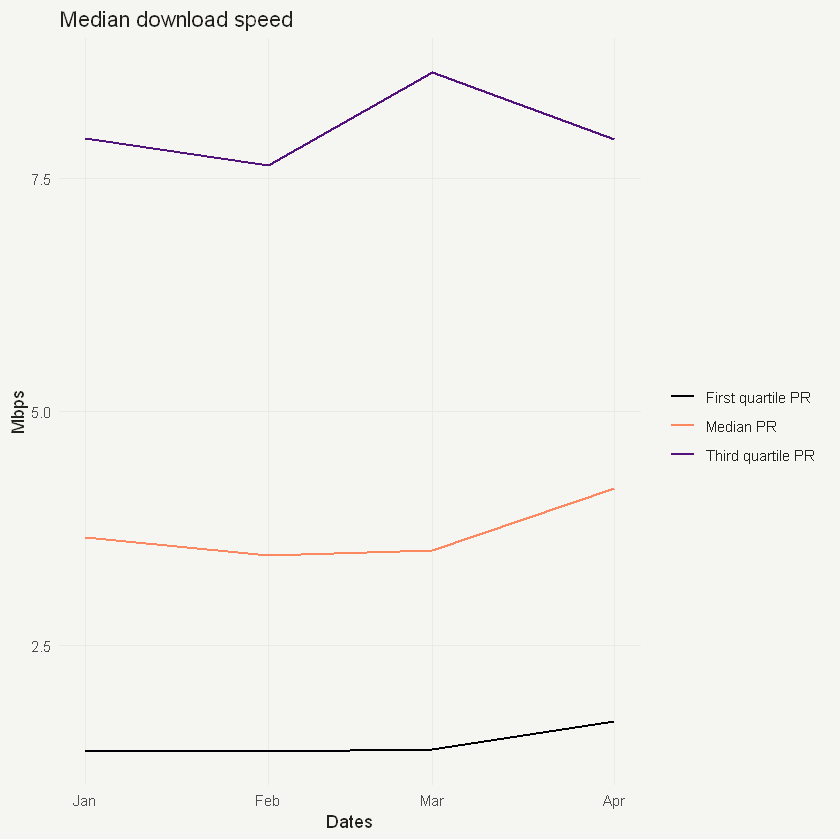

In [19]:
###Interquartile range
iqr_plot(D=D,
         cutoff_date = ymd("2010-01-01"), 
         titles = "Median download speed",
         labs =  c("First quartile PR", "Median PR", "Third quartile PR","Median mainland US"))


### Seeing the number of users per month
We might also be interested in knowing how many users are included in each time step above. The more users we have, the more confident we can be in the results. This function takes the same D as above and gives a visualization of that number over time.

Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font fa

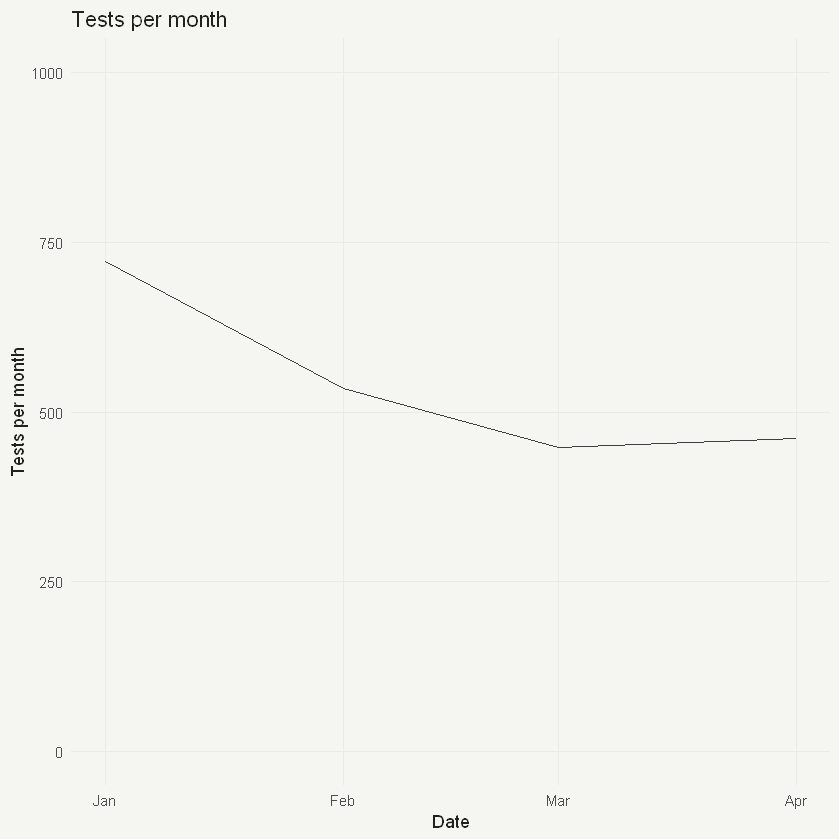

In [23]:
plot_users_per_month(D, ymd("2011-01-01"), ymd("2011-04-01"))+ ylim(0,1000)

### Viewing which speeds are most common
Another useful plot for getting a sense of what the internet speeds in an area look like is a histogram. Histograms describe the distribution of the data and describe inequalities better than many other visualization types.

The function below takes the output of the data pull above and produces a histogram of the speeds.

Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message 

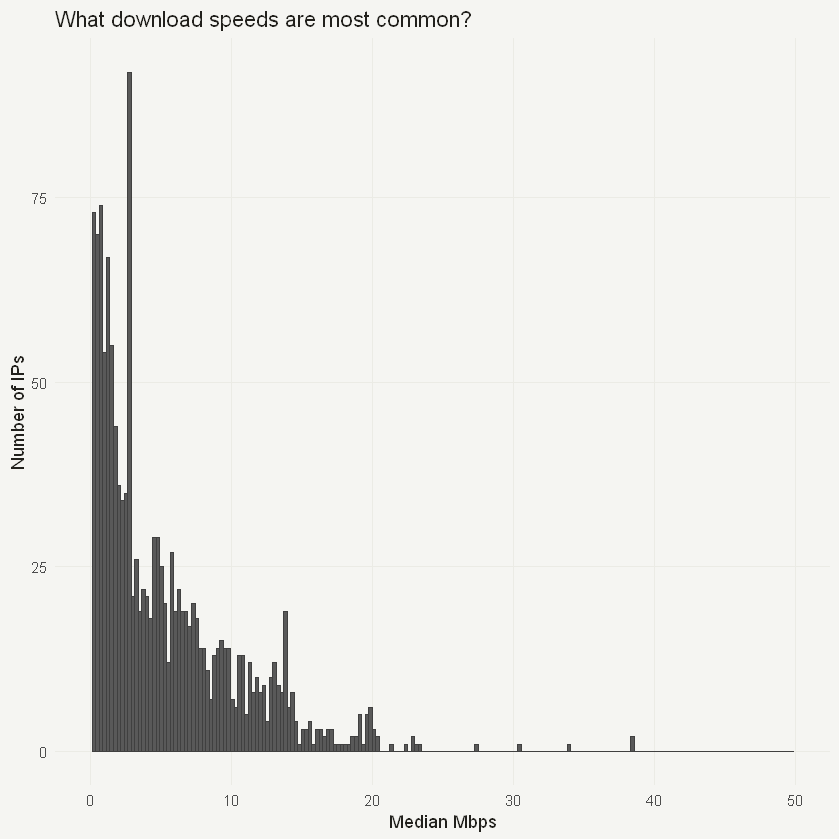

In [25]:
plot_speed_histogram(D, 50,200)

### Making a choropleth map
M-lab data natually has a spatial component to it. Oftentimes, that's the most interesting question. What does the internet look like in this region? A choropleth map is a natural answer to this question. Though they can be misleading if used improperly, they're powerful when used correctly. 

The function below takes in a date range and a region (which should correspond to the region above) and it produces a colored map where the colors represent the internet speeds in those areas.

Getting data from the 2012-2016 5-year ACS
although coordinates are longitude/latitude, st_intersects assumes that they are planar
Joining, by = "NAME"
Warning message in order(as.numeric(str_trim(lapply(str_split(levels(cols), "-"), :
"NAs introduced by coercion"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(L_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"fon

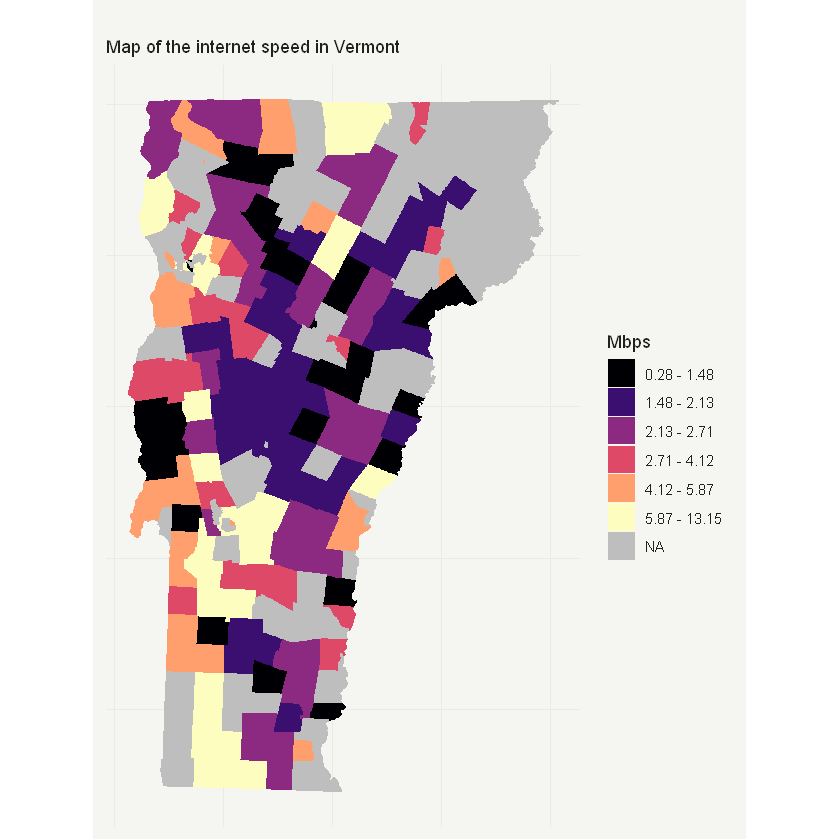

In [40]:
plot_map(D, "2009-01-01","2018-01-01","VT","Map of the internet speed in Vermont", quant=1)